In [1]:
import pandas as pd

In [2]:
df =  pd.read_csv('../data/TG_STAID002759.txt',header=14, index_col=1, parse_dates=True)
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-09-26,111448,136,0
2022-09-27,111448,112,0
2022-09-28,111448,94,0


In [3]:
suspect_df = df[df.iloc[:,2] == 1]
suspect_df

,SOUID,TG,Q_TG
DATE,,,
1947-01-21,127488,-27,1


# Missing values from 1945 so just take the data from there

In [4]:
missing_df = df[df.iloc[:,2] == 9]
missing_df

,SOUID,TG,Q_TG
DATE,,,
1945-04-25,127488,-9999,9
1945-04-26,127488,-9999,9
1945-04-27,127488,-9999,9
1945-04-28,127488,-9999,9
1945-04-29,127488,-9999,9
...,...,...,...
1945-11-01,127488,-9999,9
1945-11-02,127488,-9999,9
1945-11-03,127488,-9999,9


In [5]:
bad_values = df[df.iloc[:, 1] ==  -9999.000000]
bad_values

,SOUID,TG,Q_TG
DATE,,,
1945-04-25,127488,-9999,9
1945-04-26,127488,-9999,9
1945-04-27,127488,-9999,9
1945-04-28,127488,-9999,9
1945-04-29,127488,-9999,9
...,...,...,...
1945-11-01,127488,-9999,9
1945-11-02,127488,-9999,9
1945-11-03,127488,-9999,9


In [6]:
# Assert missing entires
assert len(pd.date_range(df.index.min(), df.index.max()).difference(df.index)) == 0 , "Missing values in date range"

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53599 entries, 1876-01-01 to 2022-09-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0    SOUID  53599 non-null  int64
 1      TG   53599 non-null  int64
 2    Q_TG   53599 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [8]:
df.describe()

,SOUID,TG,Q_TG
count,53599.000000,53599.000000,53599.000000
mean,119321.941380,57.436837,0.032762
std,8023.234672,612.756541,0.541885
min,111448.000000,-9999.000000,0.000000
25%,111448.000000,33.000000,0.000000
50%,111448.000000,94.000000,0.000000
75%,127488.000000,158.000000,0.000000
max,128124.000000,305.000000,9.000000


In [9]:
df = df.set_axis(list(map(lambda cl: cl.strip() ,df.columns)), axis=1)
df = df.rename({'TG': 'temp_c'}, axis=1)
df.columns

Index(['SOUID', 'temp_c', 'Q_TG'], dtype='object')

In [10]:
# Change tenths to full integer degrees
df['temp_c'] = df['temp_c'] / 10

In [11]:
import math
import numpy as np

def find_season(month, hemisphere='Northern') -> str:
    """Finds the season with the given month number

    Args:
        month (_type_): The month number
        hemisphere (str, optional): North or south of the equator. Defaults to 'Northern'.

    Returns:
        _type_: The season string
    """
    if hemisphere == 'Southern':
        season_month_south = {
            12: 'Summer', 1: 'Summer', 2: 'Summer',
            3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
            6: 'Winter', 7: 'Winter', 8: 'Winter',
            9: 'Spring', 10: 'Spring', 11: 'Spring'}
        return season_month_south.get(month)

    elif hemisphere == 'Northern':
        season_month_north = {
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Autumn', 10: 'Autumn', 11: 'Autumn'}
        return season_month_north.get(month)
    else:
        print('Invalid selection. Please select a hemisphere and try again')


def add_time_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Returns a Time indexed dataframe with columns with the datetime information extracted

    Args:
        df (pd.DataFrame): The time series dataframe    

    Returns:
        pd.DataFrame: The existing dataframe with new columns
    """
    df['year'] = df.index.year
    df['month'] = df.index.month_name()
    df['day_of_week'] = df.index.day_name()

    
    df['month_sin'] = np.sin(2 * math.pi  * df.index.month/12)
    df['month_cos'] = np.cos(2 * math.pi  * df.index.month/12)
    
    df['season'] = df.index.month.map(find_season)


    df['is_weekend'] = ((df['day_of_week'] == 'Saturday') |
                        (df['day_of_week'] == 'Sunday')).astype(int)
    return df

In [12]:
df = add_time_columns(df)
df

,SOUID,temp_c,Q_TG,year,month,day_of_week,month_sin,month_cos,season,is_weekend
DATE,,,,,,,,,,
1876-01-01,127488,2.2,0,1876,January,Saturday,0.5,8.660254e-01,Winter,1
1876-01-02,127488,2.5,0,1876,January,Sunday,0.5,8.660254e-01,Winter,1
1876-01-03,127488,0.3,0,1876,January,Monday,0.5,8.660254e-01,Winter,0
1876-01-04,127488,-5.8,0,1876,January,Tuesday,0.5,8.660254e-01,Winter,0
1876-01-05,127488,-9.8,0,1876,January,Wednesday,0.5,8.660254e-01,Winter,0
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,111448,13.6,0,2022,September,Monday,-1.0,-1.836970e-16,Autumn,0
2022-09-27,111448,11.2,0,2022,September,Tuesday,-1.0,-1.836970e-16,Autumn,0
2022-09-28,111448,9.4,0,2022,September,Wednesday,-1.0,-1.836970e-16,Autumn,0


In [13]:
# REMOVE INVALID VALUES FROM THE DATA
df = df[df['Q_TG'] == 0]

<AxesSubplot:xlabel='    DATE'>

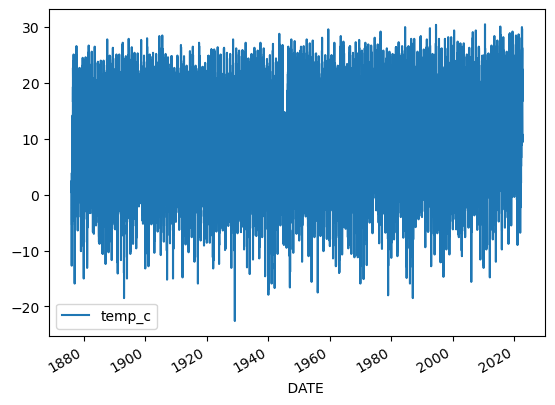

In [14]:
df.plot(y='temp_c')

Yearly Average

<AxesSubplot:xlabel='    DATE'>

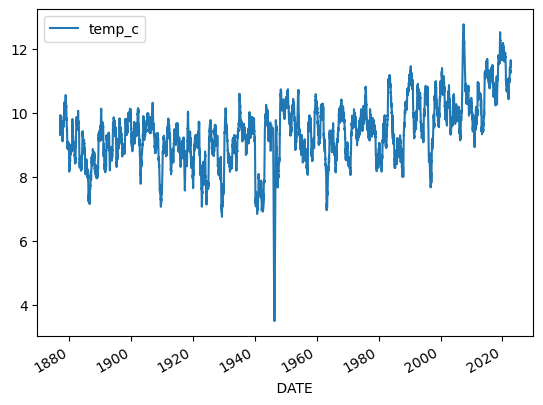

In [15]:
df.rolling(365).mean().plot(y='temp_c')

Decade average

<AxesSubplot:xlabel='    DATE'>

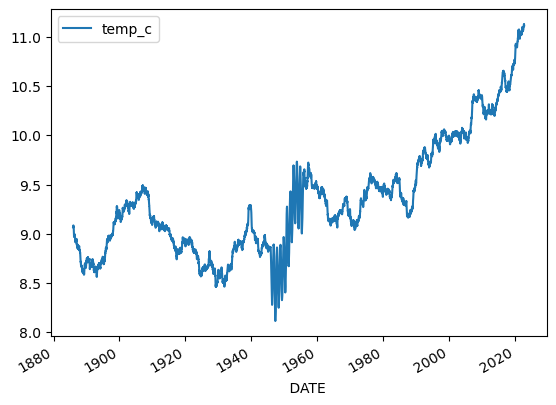

In [16]:
df.rolling(365 * 10).mean().plot(y='temp_c')

# Century

Average

<AxesSubplot:xlabel='    DATE'>

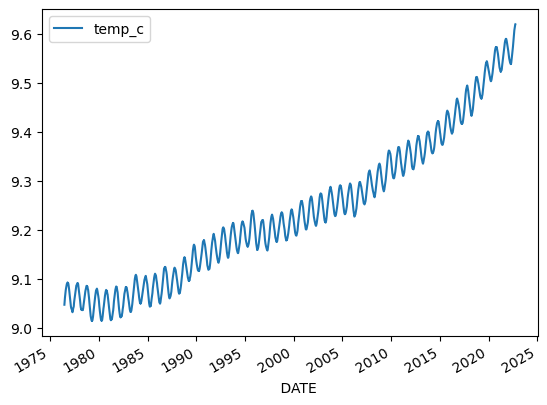

In [17]:
df.rolling(365 * 10 * 10).mean().plot(y='temp_c')

Min yearly

<AxesSubplot:xlabel='    DATE'>

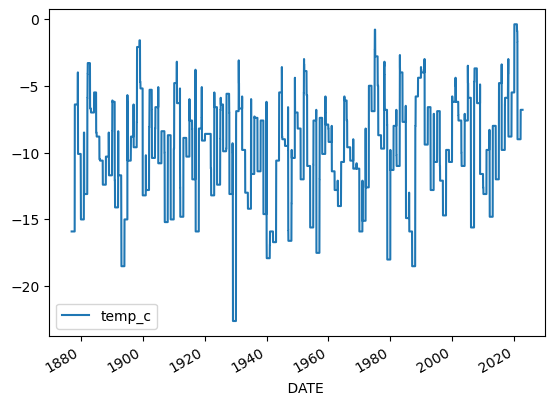

In [18]:
df.rolling(365).min().plot(y='temp_c')

Max yearly

<AxesSubplot:xlabel='    DATE'>

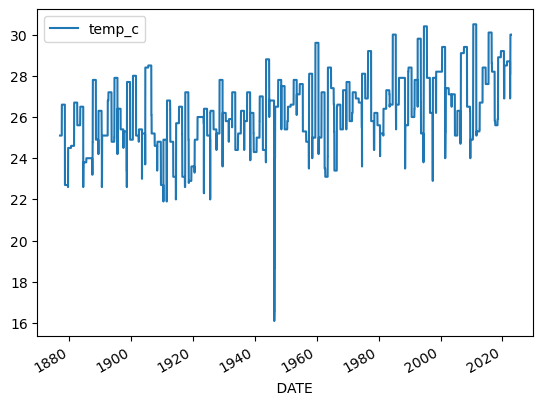

In [19]:
df.rolling(365).max().plot(y='temp_c')

In [20]:
df.groupby('year')['temp_c'].min()

year
1876   -15.9
1877    -6.4
1878    -4.0
1879   -15.0
1880    -8.5
        ... 
2018    -8.8
2019    -5.5
2020    -0.9
2021    -9.0
2022    -2.3
Name: temp_c, Length: 147, dtype: float64

In [21]:
df['temp_c'].rolling(365).min()  

    DATE
1876-01-01    NaN
1876-01-02    NaN
1876-01-03    NaN
1876-01-04    NaN
1876-01-05    NaN
             ... 
2022-09-26   -6.8
2022-09-27   -6.8
2022-09-28   -6.8
2022-09-29   -6.8
2022-09-30   -6.8
Name: temp_c, Length: 53403, dtype: float64

# Get Coldest min temperature year

In [22]:
coldest_avg_year_df = df.groupby('year')['temp_c'].min()[df.groupby('year')['temp_c'].min() == df.groupby('year')['temp_c'].min().min()]
coldest_avg_year_df

year
1929   -22.6
Name: temp_c, dtype: float64

In [23]:
coldest_year = coldest_avg_year_df.index.values[0]
coldest_year_df = df[df['year'] == coldest_year]

# Plot the coldest year

<AxesSubplot:xlabel='    DATE'>

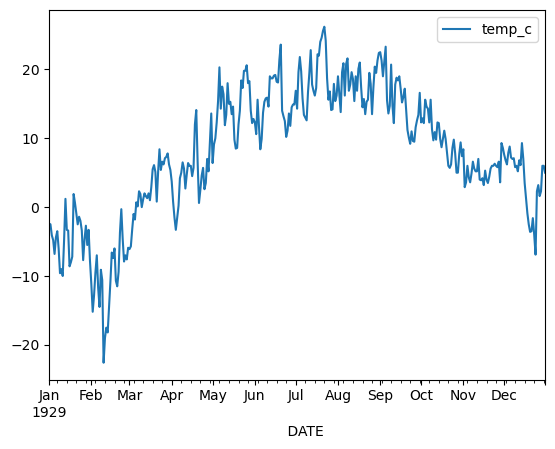

In [24]:
coldest_year_df.plot(y='temp_c')

In [25]:
df[df['year'] == coldest_avg_year_df.index[0] ]

,SOUID,temp_c,Q_TG,year,month,day_of_week,month_sin,month_cos,season,is_weekend
DATE,,,,,,,,,,
1929-01-01,127488,-2.4,0,1929,January,Tuesday,5.000000e-01,0.866025,Winter,0
1929-01-02,127488,-2.5,0,1929,January,Wednesday,5.000000e-01,0.866025,Winter,0
1929-01-03,127488,-4.1,0,1929,January,Thursday,5.000000e-01,0.866025,Winter,0
1929-01-04,127488,-4.8,0,1929,January,Friday,5.000000e-01,0.866025,Winter,0
1929-01-05,127488,-6.8,0,1929,January,Saturday,5.000000e-01,0.866025,Winter,1
...,...,...,...,...,...,...,...,...,...,...
1929-12-27,127488,1.6,0,1929,December,Friday,-2.449294e-16,1.000000,Winter,0
1929-12-28,127488,2.3,0,1929,December,Saturday,-2.449294e-16,1.000000,Winter,1
1929-12-29,127488,6.0,0,1929,December,Sunday,-2.449294e-16,1.000000,Winter,1


# Group by Seasonality

In [26]:
df.groupby('season')['temp_c'].mean()

season
Autumn     9.529404
Spring     8.988048
Summer    18.243389
Winter     0.778850
Name: temp_c, dtype: float64

<AxesSubplot:xlabel='season'>

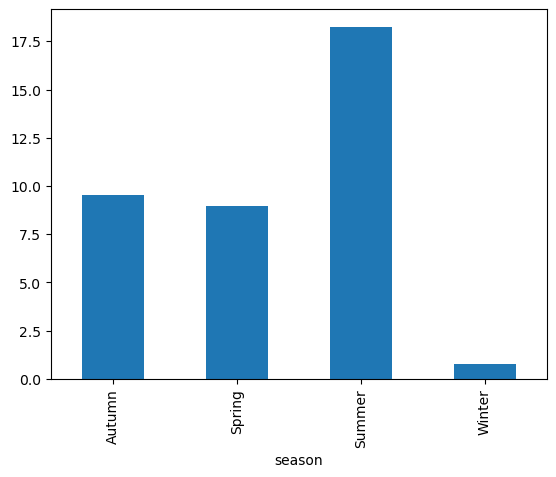

In [27]:
df.groupby('season')['temp_c'].mean().plot.bar()

In [28]:
!pip3 install seaborn


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


<AxesSubplot:>

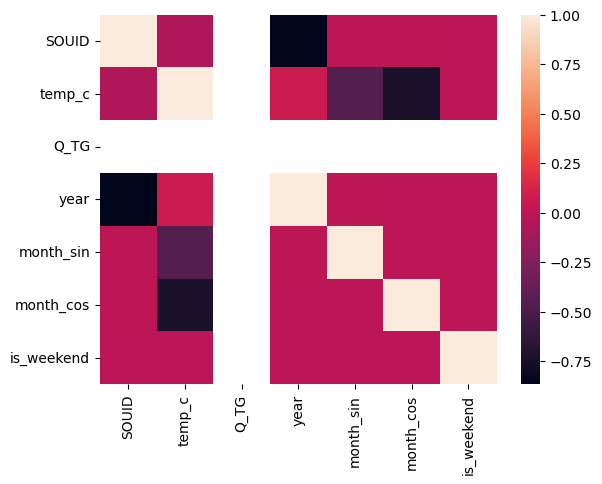

In [29]:
import seaborn as sns

sns.heatmap(df.corr())